# **Model GRU dla przewidywania pogody**

# Predykcja temperatury

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def prepare_data(data_path: str, city_name: str, x_len: int, y_len: int, train_size: float) -> list:
    """Preprocess data and return train and test sequences.

    Args:
        data_path (str): Path to data file.
        city_name (str): Name of city for which data will be extracted.
        x_len (int): Length of single X sequence.
        y_len (int): Length of single y sequence.
        train_size (float): Specifies proportion of train data to all data.

    Returns:
       (list): List containing train-test split of data.
    """

    # Read data
    df: pd.DataFrame = pd.read_csv(data_path, usecols=['datetime', city_name]).dropna()

    # Calculate mean value for each day
    df['date'] = pd.to_datetime(df['datetime'])
    data: np.ndarray = df.groupby(df['date'].dt.date)[city_name].mean().to_numpy()

    # Prepare X and y sequences
    num_sequences: int = data.size + 1 - x_len - y_len
    X = np.zeros((num_sequences, x_len), dtype=np.float32)
    y = np.zeros((num_sequences, y_len), dtype=np.float32)
    for i in range(num_sequences):
        X[i] = data[i:(i+x_len)]
        y[i] = data[i+x_len:(i+x_len+y_len)]

    # Return train and test sequences
    train_len = int(num_sequences * train_size)
    return [X[:train_len], X[train_len:], y[:train_len], y[train_len:]]


In [3]:
def draw_training_process(history, key1='mse') -> None:
    """Draws a plot of training process.

    Args:
      history (keras.callbacks.History): object that contains information about the training process.
      key1 (str): Specifies the key in 'history.history' to plot on the y-axis, for example "mse".

    Returns:
      None
    """
    plt.figure(figsize=(12,6))
    plt.plot(np.log(history.history[key1]), "r--")
    plt.plot(np.log(history.history['val_' + key1]), "g--")
    plt.ylabel(key1)
    plt.xlabel('Epoch')
    plt.title(f"Training process")
    plt.legend(['train', 'test'], loc='best')
 
    plt.show()

def metrics_and_plots(history,y_true,y_pred,y_len) -> None:
  """Draws plots of weather predictions and calculates evaluation metrics.

  Args:
    history (keras.callbacks.History): object that contains information about the training process.
    y_true (np.array): A numpy array of shape (n_samples, n_features) that contains true values of weather variables.
    y_pred (np.array): A numpy array of shape (n_samples, n_features) that contains predicted values of weather variables.
    y_len (int): Specifies the number of days to plot and calculate metrics for, at our place 4.

  Returns:
    None
  """
  #draws a plot of training process
  draw_training_process(history,key1='mse')

  #draws plots of weather predictions
  print("Weather predictions")
  fig, axes = plt.subplots(y_len, 1, figsize=(8, 24), sharex=False)
  for i in range(y_len):
    axes[i].plot(y_test[:, i], label='True values')
    axes[i].plot(y_pred[:, i], label='Predicted values')
    axes[i].set_xlabel("Day in year")
    axes[i].set_ylabel("Temperature (K)")
    axes[i].legend()
    axes[i].set_title(f"Day {i+1}")
  plt.show()

  #calculate metrics 
  print("Metrics for 4 consecutive days")
  for i in range(y_len):
    y_true = y_test[:, i]
    y_pred_day = y_pred[:,i]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_day))
    mse = mean_squared_error(y_true, y_pred_day)
    mae = mean_absolute_error(y_true, y_pred_day)
    r2 = r2_score(y_true, y_pred_day)
    pearson, _ = pearsonr(y_true, y_pred_day)
    ia = (1 -(np.sum((y_pred_day-y_true)**2))/(np.sum((np.abs(y_true-np.mean(y_pred_day))+np.abs(y_pred_day-np.mean(y_pred_day)))**2)))
    print(f"Day {i+1}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}, Pearson={pearson:.4f}, IA={ia:.4f}")


Vancouver

In [4]:
data_path = './temperature.csv'
city_name = 'Vancouver'
x_len = 4
y_len = 4
train_size = 0.8
X_train, X_test, y_train, y_test = prepare_data(data_path, city_name, x_len, y_len, train_size)

In [7]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Activation, LSTM, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

model = Sequential()
model.add(GRU(64, activation='linear', input_shape=(x_len, 1)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(y_len))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.summary()

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

y_pred = model.predict(X_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 21,444
Trainable params: 21,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 4s 22ms/step - loss: 11912.7998 - mse: 11912.7998 - val_loss: 300.8289 - val_mse: 300.8289
Epoch 2/50
37/37 [=====================

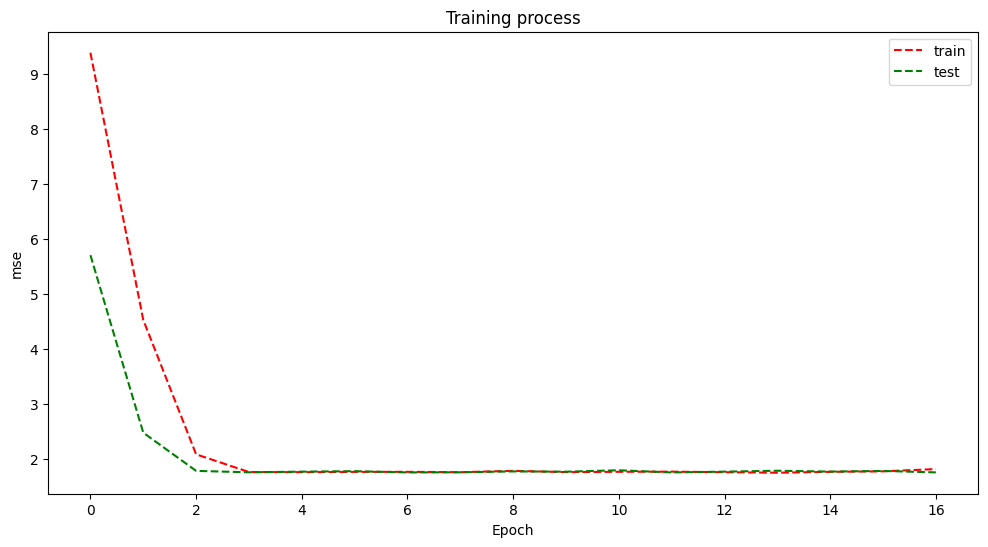

Weather predictions


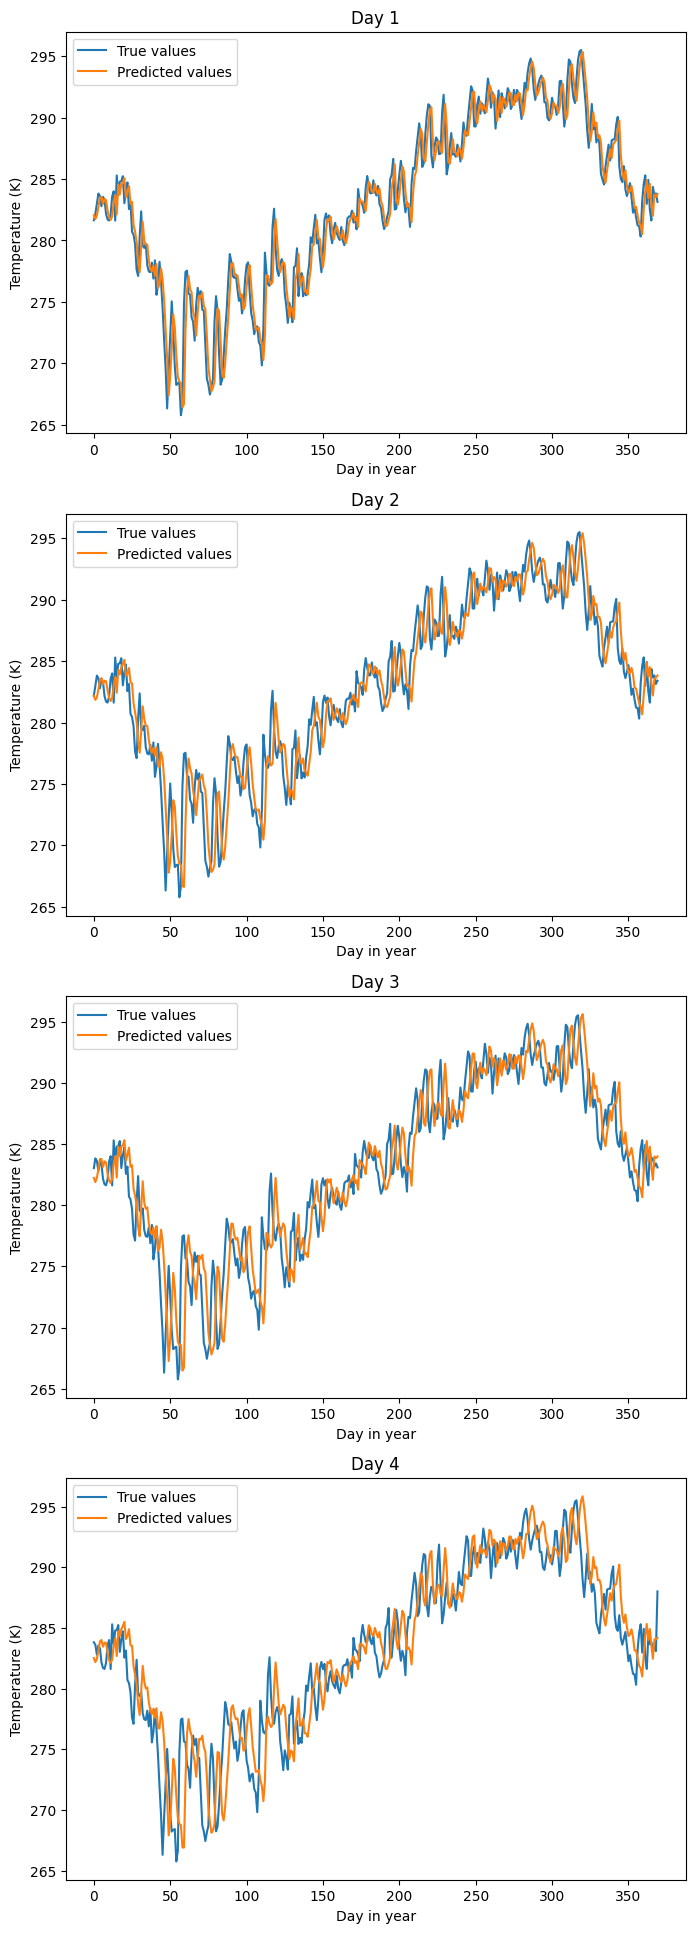

Metrics for 4 consecutive days
Day 1: RMSE=1.6899, MSE=2.8558, MAE=1.3165, R^2=0.9389, Pearson=0.9692, IA=0.9844
Day 2: RMSE=2.4194, MSE=5.8533, MAE=1.8530, R^2=0.8748, Pearson=0.9369, IA=0.9675
Day 3: RMSE=2.7942, MSE=7.8074, MAE=2.1518, R^2=0.8329, Pearson=0.9162, IA=0.9563
Day 4: RMSE=2.9745, MSE=8.8479, MAE=2.3082, R^2=0.8110, Pearson=0.9065, IA=0.9504


In [8]:
metrics_and_plots(history,y_test,y_pred,y_len)

Los Angeles

In [11]:
data_path = './temperature.csv'
city_name = 'Los Angeles'
x_len = 4
y_len = 4
train_size = 0.8
X_train, X_test, y_train, y_test = prepare_data(data_path, city_name, x_len, y_len, train_size)

In [16]:
model = Sequential()
model.add(GRU(64, activation='linear', input_shape=(x_len, 1)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(y_len))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.summary()

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

y_pred = model.predict(X_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, 64)                12864     
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 4)                 260       
                                                                 
Total params: 21,444
Trainable params: 21,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 3s 36ms/step - loss: 17913.6230 - mse: 17913.6230 - val_loss: 486.6056 - val_mse: 486.6056
Epoch 2/50
38/38 [=====================

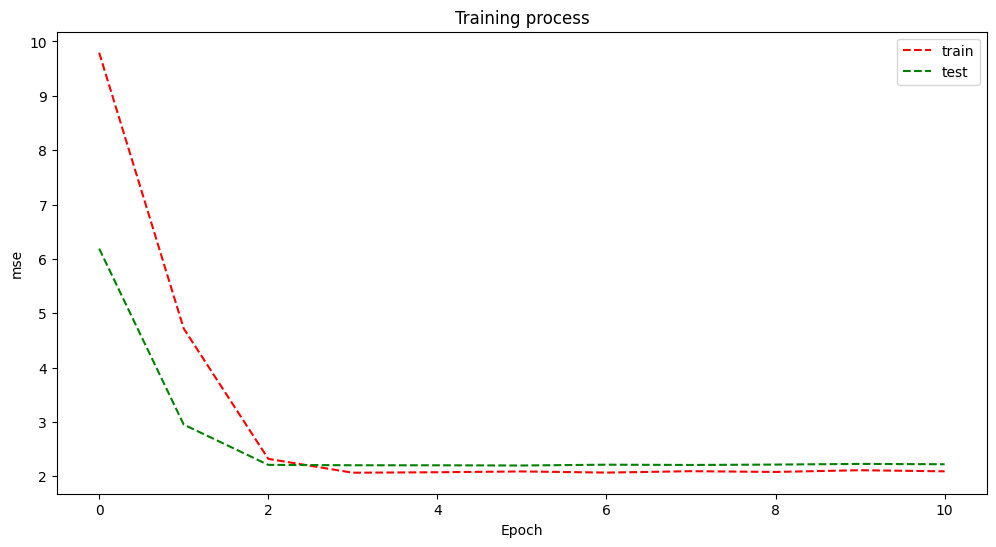

Weather predictions


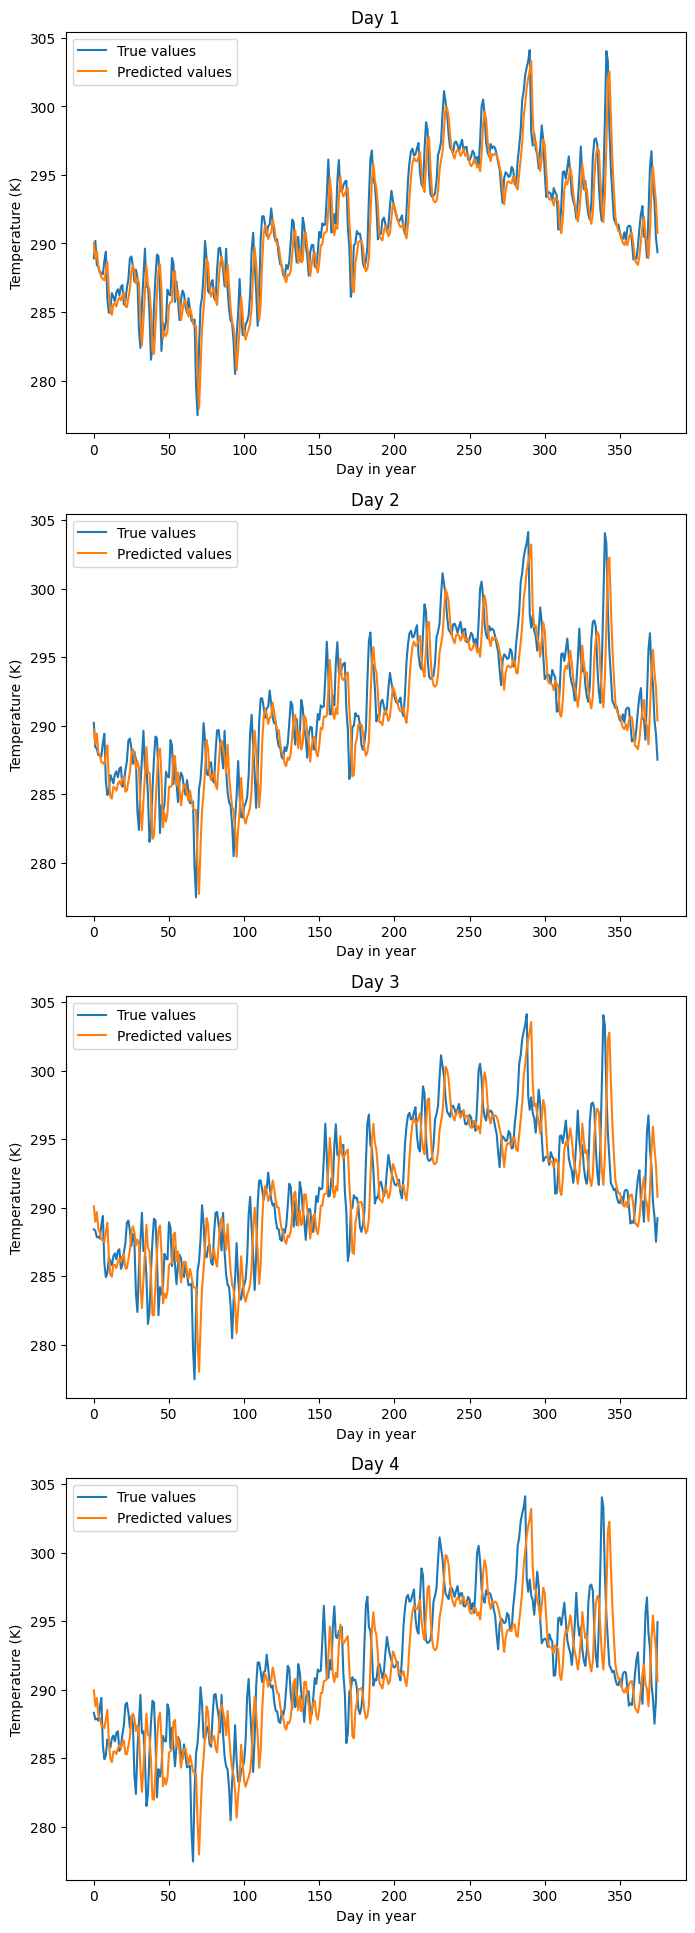

Metrics for 4 consecutive days
Day 1: RMSE=1.7863, MSE=3.1907, MAE=1.3514, R^2=0.8534, Pearson=0.9310, IA=0.9614
Day 2: RMSE=2.5826, MSE=6.6699, MAE=1.9534, R^2=0.6939, Pearson=0.8533, IA=0.9168
Day 3: RMSE=3.0140, MSE=9.0842, MAE=2.2622, R^2=0.5833, Pearson=0.7895, IA=0.8834
Day 4: RMSE=3.2681, MSE=10.6808, MAE=2.4732, R^2=0.5102, Pearson=0.7579, IA=0.8611


In [17]:
metrics_and_plots(history,y_test,y_pred,y_len)

Nowy Jork na podstwie wyuczonego modelu LA

In [18]:
data_path = './temperature.csv'
city_name = 'New York'
x_len = 4
y_len = 4
train_size = 0.8
X_train, X_test, y_train, y_test = prepare_data(data_path, city_name, x_len, y_len, train_size)

In [19]:
y_pred = model.predict(X_test)

12/12 [==============================] - 0s 3ms/step


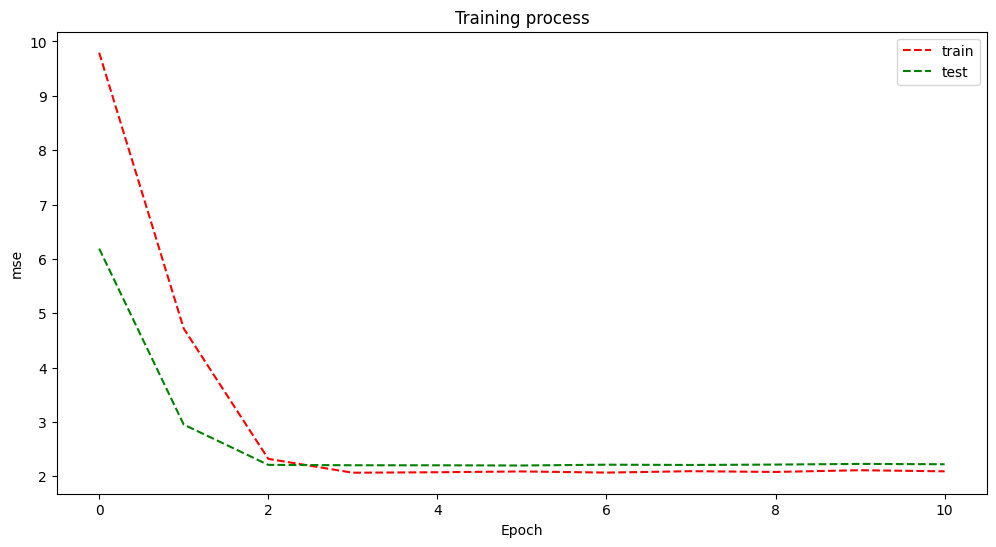

Weather predictions


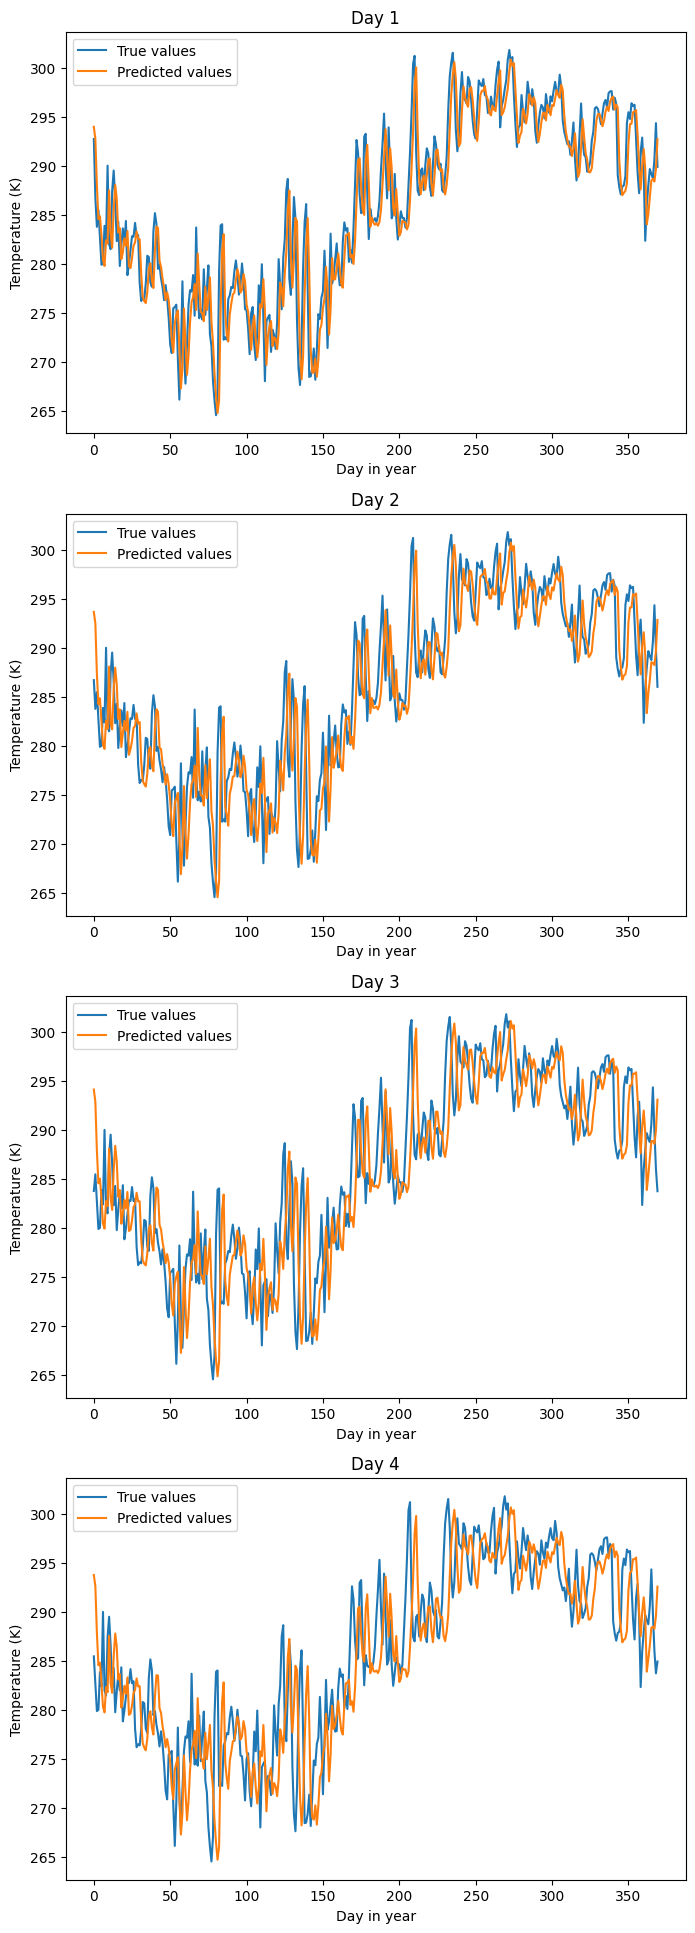

Metrics for 4 consecutive days
Day 1: RMSE=3.3958, MSE=11.5311, MAE=2.6151, R^2=0.8590, Pearson=0.9295, IA=0.9629
Day 2: RMSE=4.6793, MSE=21.8963, MAE=3.5717, R^2=0.7319, Pearson=0.8655, IA=0.9274
Day 3: RMSE=5.2142, MSE=27.1879, MAE=3.9642, R^2=0.6672, Pearson=0.8309, IA=0.9085
Day 4: RMSE=5.2959, MSE=28.0470, MAE=4.0082, R^2=0.6566, Pearson=0.8263, IA=0.9051


In [20]:
metrics_and_plots(history,y_test,y_pred,y_len)

# Predykcja wiatru

In [21]:
def metrics_and_plots_wind(history,y_true,y_pred,y_len) -> None:
  """Draws plots of weather predictions and calculates evaluation metrics.

  Args:
    history (keras.callbacks.History): object that contains information about the training process.
    y_true (np.array): A numpy array of shape (n_samples, n_features) that contains true values of weather variables.
    y_pred (np.array): A numpy array of shape (n_samples, n_features) that contains predicted values of weather variables.
    y_len (int): Specifies the number of days to plot and calculate metrics for, at our place 4.

  Returns:
    None
  """
  #draws a plot of training process
  draw_training_process(history,key1='mse')

  #draws plots of weather predictions
  print("Weather predictions")
  fig, axes = plt.subplots(y_len, 1, figsize=(8, 24), sharex=False)
  for i in range(y_len):
    axes[i].plot(y_test[:, i], label='True values')
    axes[i].plot(y_pred[:, i], label='Predicted values')
    axes[i].set_xlabel("Day in year")
    axes[i].set_ylabel("Wind speed")
    axes[i].legend()
    axes[i].set_title(f"Day {i+1}")
  plt.show()

  #calculate metrics 
  print("Metrics for 4 consecutive days")
  for i in range(y_len):
    y_true = y_test[:, i]
    y_pred_day = y_pred[:,i]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_day))
    mse = mean_squared_error(y_true, y_pred_day)
    mae = mean_absolute_error(y_true, y_pred_day)
    r2 = r2_score(y_true, y_pred_day)
    pearson, _ = pearsonr(y_true, y_pred_day)
    ia = (1 -(np.sum((y_pred_day-y_true)**2))/(np.sum((np.abs(y_true-np.mean(y_pred_day))+np.abs(y_pred_day-np.mean(y_pred_day)))**2)))
    print(f"Day {i+1}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}, Pearson={pearson:.4f}, IA={ia:.4f}")


Vancouver

In [28]:
data_path = './wind_speed.csv'
city_name = 'Vancouver'
x_len = 4
y_len = 4
train_size = 0.8
X_train, X_test, y_train, y_test = prepare_data(data_path, city_name, x_len, y_len, train_size)

In [29]:
model = Sequential()
model.add(GRU(64, activation='linear', input_shape=(x_len, 1)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(y_len))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.summary()

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

y_pred = model.predict(X_test)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 64)                12864     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 4)                 260       
                                                                 
Total params: 21,444
Trainable params: 21,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 3s 15ms/step - loss: 2.3987 - mse: 2.3987 - val_loss: 1.8570 - val_mse: 1.8570
Epoch 2/50
37/37 [==============================] -

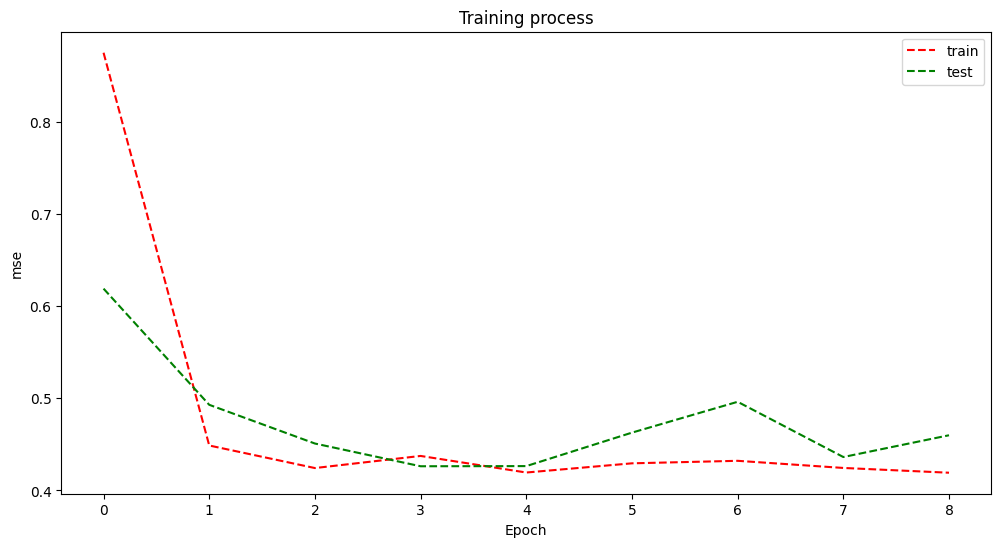

Weather predictions


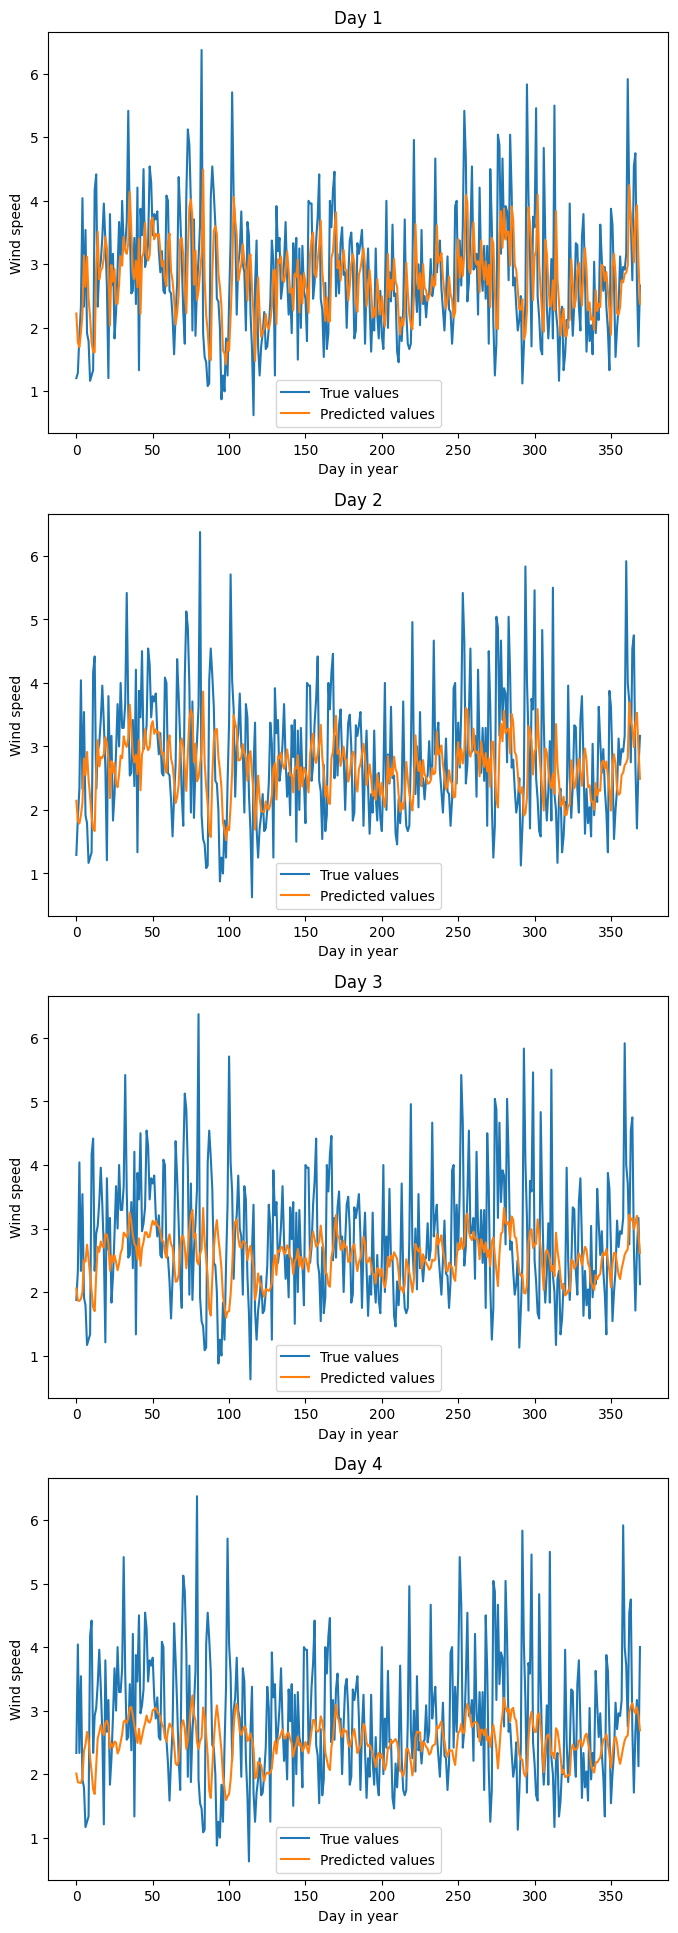

Metrics for 4 consecutive days
Day 1: RMSE=0.9899, MSE=0.9800, MAE=0.7695, R^2=0.0277, Pearson=0.3071, IA=0.5348
Day 2: RMSE=1.0793, MSE=1.1648, MAE=0.8291, R^2=-0.1638, Pearson=0.0675, IA=0.3488
Day 3: RMSE=1.0900, MSE=1.1881, MAE=0.8323, R^2=-0.1932, Pearson=0.0137, IA=0.2833
Day 4: RMSE=1.0755, MSE=1.1566, MAE=0.8231, R^2=-0.1605, Pearson=0.0957, IA=0.2988


In [30]:
metrics_and_plots_wind(history,y_test,y_pred,y_len)

Los Angeles

In [31]:
data_path = './wind_speed.csv'
city_name = 'Los Angeles'
x_len = 4
y_len = 4
train_size = 0.8
X_train, X_test, y_train, y_test = prepare_data(data_path, city_name, x_len, y_len, train_size)

In [33]:
model = Sequential()
model.add(GRU(64, activation='linear', input_shape=(x_len, 1)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(y_len))

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.summary()

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

y_pred = model.predict(X_test)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 64)                12864     
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 4)                 260       
                                                                 
Total params: 21,444
Trainable params: 21,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 3s 15ms/step - loss: 0.3830 - mse: 0.3830 - val_loss: 0.4952 - val_mse: 0.4952
Epoch 2/50
38/38 [==============================] 

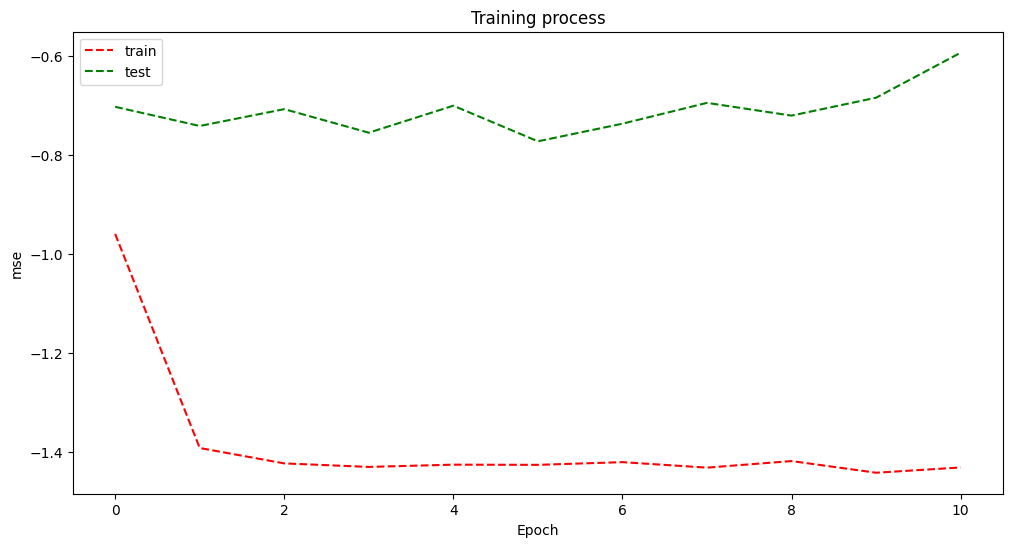

Weather predictions


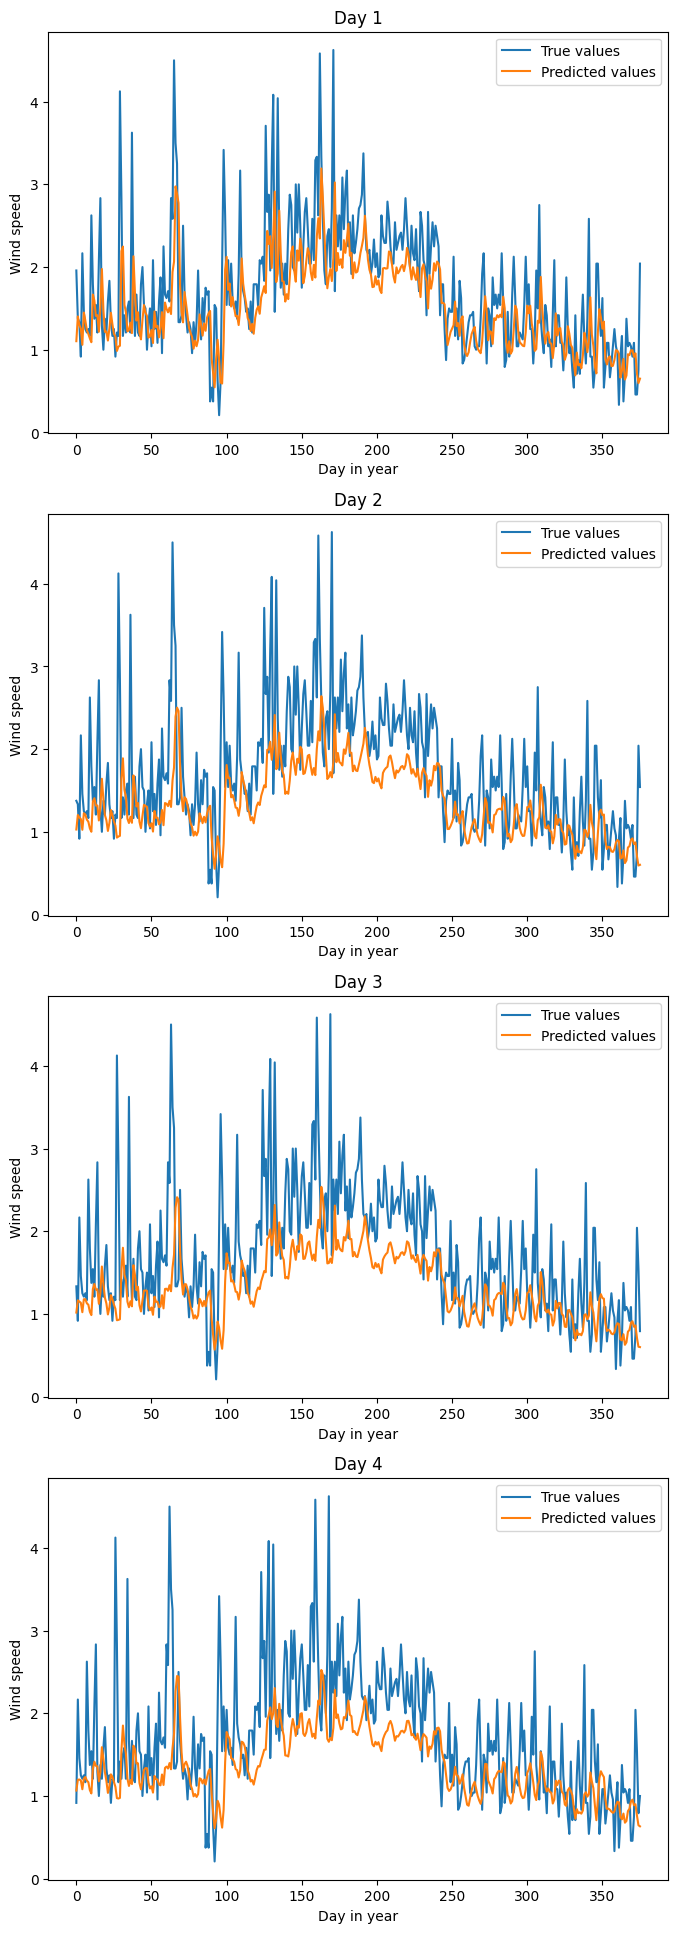

Metrics for 4 consecutive days
Day 1: RMSE=0.6287, MSE=0.3953, MAE=0.4361, R^2=0.2902, Pearson=0.6276, IA=0.7243
Day 2: RMSE=0.7389, MSE=0.5460, MAE=0.5300, R^2=0.0196, Pearson=0.5436, IA=0.6035
Day 3: RMSE=0.7603, MSE=0.5781, MAE=0.5492, R^2=-0.0341, Pearson=0.5353, IA=0.5766
Day 4: RMSE=0.7335, MSE=0.5380, MAE=0.5238, R^2=0.0393, Pearson=0.5353, IA=0.5862


In [34]:
metrics_and_plots_wind(history,y_test,y_pred,y_len)

Nowy Jork dla wyuczonego modelu

In [35]:
data_path = './wind_speed.csv'
city_name = 'New York'
x_len = 4
y_len = 4
train_size = 0.8
X_train, X_test, y_train, y_test = prepare_data(data_path, city_name, x_len, y_len, train_size)

In [36]:
y_pred = model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


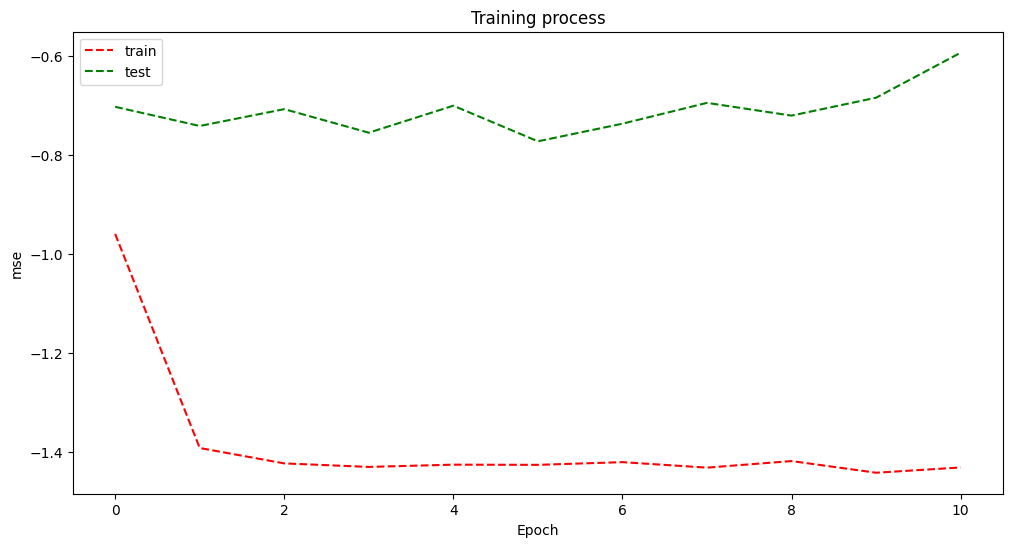

Weather predictions


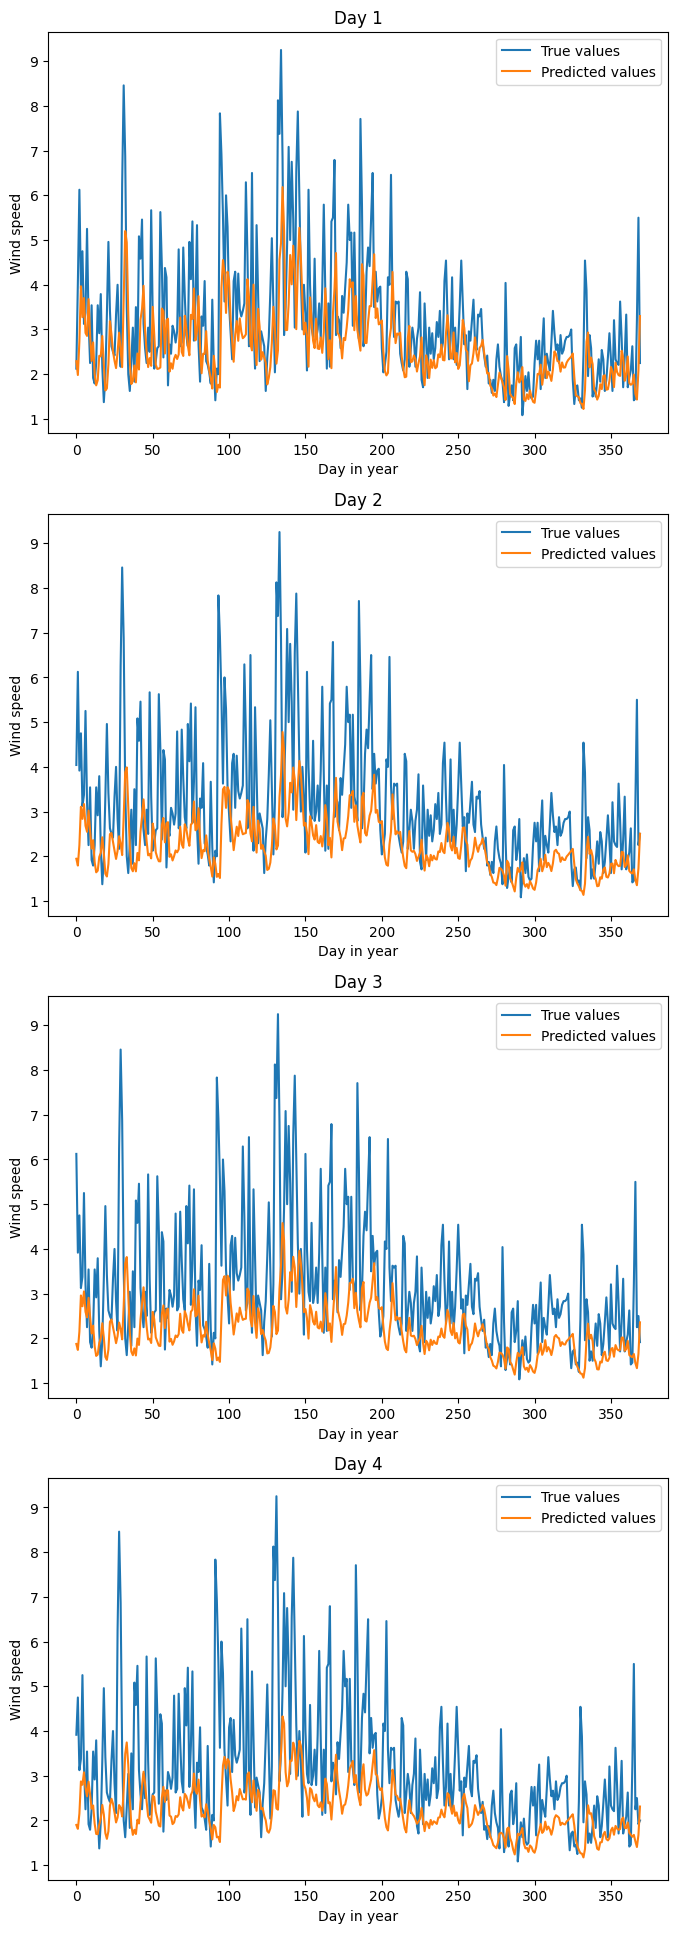

Metrics for 4 consecutive days
Day 1: RMSE=1.3734, MSE=1.8863, MAE=0.9587, R^2=0.0591, Pearson=0.5114, IA=0.6027
Day 2: RMSE=1.6674, MSE=2.7801, MAE=1.1649, R^2=-0.3880, Pearson=0.3080, IA=0.3811
Day 3: RMSE=1.7067, MSE=2.9129, MAE=1.1841, R^2=-0.4523, Pearson=0.3096, IA=0.3648
Day 4: RMSE=1.6445, MSE=2.7044, MAE=1.1494, R^2=-0.3611, Pearson=0.3455, IA=0.3744


In [37]:
metrics_and_plots_wind(history,y_test,y_pred,y_len)